## Sequential analysis: peeking vs valid monitoring
This notebook demonstrates why naïve peeking (re-checking p-values repeatedly) inflates type I error, and how sequential monitoring fixes it.

We cover (v1):
- 
- Two-group A/B (control vs test)
- Mean metric (difference in means, user-level)
- Naïve repeated looks (invalid)
- Group sequential monitoring (valid for K pre-defined looks)
  
Outputs:

- Look table (per-look stats)
- z-trajectory vs boundaries
- Empirical type I error comparison via simulation
  
Notes:

- This implementation uses a normal approximation and Welch-style SE; interpret results accordingly.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

from tecore.sequential.schema import (
    SequentialSpec,
    LookSchedule,
    SequentialConfig,
    SequentialMode,
    SpendingFunction,
    EffectDirection,
)
from tecore.sequential.preprocess import build_look_table_mean
from tecore.sequential.group_sequential import run_group_sequential
from tecore.sequential.simulate import SequentialSimConfig, simulate_ab_stream

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

def fixed_p_from_z(z: float, two_sided: bool = True) -> float:
    if not np.isfinite(z):
        return np.nan
    return float(2 * norm.sf(abs(z))) if two_sided else float(norm.sf(z))

def run_naive_peeking_mean(df: pd.DataFrame, looks: list[int], alpha: float = 0.05) -> dict:
    """Naïve repeated testing: compute a standard fixed-horizon p-value at each look,
    and declare significance if ANY look has p < alpha.

    This inflates type I error.
    """
    spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y", timestamp_col="timestamp")
    schedule = LookSchedule(looks=looks)
    cfg = SequentialConfig(
        mode=SequentialMode.GROUP_SEQUENTIAL,
        alpha=alpha,
        two_sided=True,
        spending=SpendingFunction.OBRIEN_FLEMING,
        effect_direction=EffectDirection.TWO_SIDED,
        min_n_per_group=10,
        var_floor=1e-12,
        seed=0,
    )
    lt, warn = build_look_table_mean(df, spec, schedule, cfg)
    z = pd.to_numeric(lt["z"], errors="coerce").to_numpy(dtype=float)
    p = np.array([fixed_p_from_z(zi, two_sided=True) for zi in z], dtype=float)
    stop_idx = int(np.where(p < alpha)[0][0]) if np.any(p < alpha) else None
    return {
        "look_table": lt.assign(p_fixed=p),
        "warnings": warn,
        "rejected": bool(stop_idx is not None),
        "stop_look": int(lt.iloc[stop_idx]["look_n"]) if stop_idx is not None else None,
        "min_p": float(np.nanmin(p)),
    }

## 1) Single run: how peeking can “find significance” under the null
We simulate a null effect stream (effect=0), check a sequence of looks, and compare:

- Naïve repeated testing (invalid)
- Group sequential O’Brien-Fleming (valid for the schedule)

In [13]:
N = 5000
looks = [500, 1000, 1500, 2000, 3000, 4000, 5000]
alpha = 0.05

df = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.0, noise_sd=1.0, heavy_tail=False, drift=False, seed=7, ratio=False))

# Naïve peeking
naive = run_naive_peeking_mean(df, looks=looks, alpha=alpha)
lt_naive = naive["look_table"].copy()

# Group sequential (OBF)
spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y", timestamp_col="timestamp")
schedule = LookSchedule(looks=looks)
cfg_gs = SequentialConfig(
    mode=SequentialMode.GROUP_SEQUENTIAL,
    alpha=alpha,
    two_sided=True,
    spending=SpendingFunction.OBRIEN_FLEMING,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=10,
    var_floor=1e-12,
    seed=7,
)
lt, warn = build_look_table_mean(df, spec, schedule, cfg_gs)
res_gs = run_group_sequential(lt, cfg_gs)

display(lt_naive.head())
print("Naïve rejected?", naive["rejected"], "stop_look=", naive["stop_look"], "min_p=", naive["min_p"])
print("Group sequential decision:", res_gs.decision, "stopped=", res_gs.stopped, "stop_look=", res_gs.stop_look)

Naïve rejected? False stop_look= None min_p= 0.3775688788883641
Group sequential decision: continue stopped= False stop_look= None


,n_control,n_test,mean_control,mean_test,var_control,var_test,diff,se,z,info,look_n,p_fixed
0,235,265,0.007195,0.018835,1.065974,0.862538,0.011640,0.088266,0.131872,128.354513,500,0.895086
1,502,498,-0.006986,0.015570,0.992612,1.028916,0.022556,0.063588,0.354717,247.315926,1000,0.722801
2,752,748,-0.027309,0.008573,0.991851,1.015463,0.035882,0.051735,0.693573,373.619377,1500,0.487950
3,1013,987,-0.009221,-0.017718,0.966033,0.992174,-0.008497,0.044259,-0.191972,510.496298,2000,0.847764
4,1496,1504,-0.009028,-0.040493,0.937563,0.969835,-0.031465,0.035659,-0.882385,786.441766,3000,0.377569


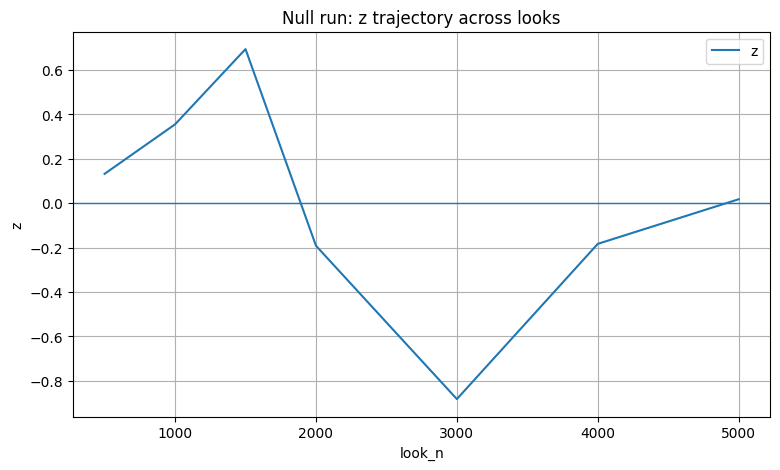

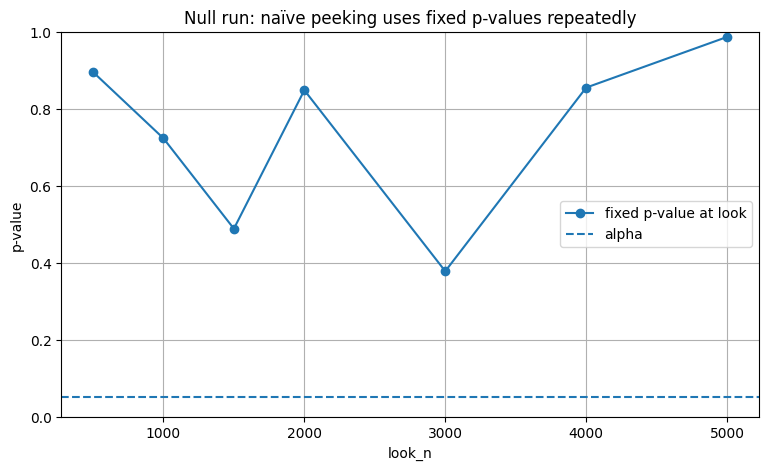

In [14]:
x = lt_naive["look_n"].to_numpy()
z = lt_naive["z"].to_numpy(dtype=float)
p = lt_naive["p_fixed"].to_numpy(dtype=float)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, z, label="z")
ax1.axhline(0.0, linewidth=1.0)
ax1.set_xlabel("look_n")
ax1.set_ylabel("z")
ax1.set_title("Null run: z trajectory across looks")
ax1.legend(loc="best")
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(x, p, marker="o", label="fixed p-value at look")
ax2.axhline(alpha, linestyle="--", label="alpha")
ax2.set_xlabel("look_n")
ax2.set_ylabel("p-value")
ax2.set_title("Null run: naïve peeking uses fixed p-values repeatedly")
ax2.set_ylim(0, 1)
ax2.legend(loc="best")
plt.show()

## 2) Simulation: type I error inflation from peeking
We estimate the empirical type I error under the null:

- Naïve peeking: reject if any look has fixed p < alpha
- Group sequential (OBF): reject if boundary is crossed

Expectation:

- Naïve peeking will typically exceed alpha
- Group sequential should be close to alpha (within Monte Carlo noise)

Empirical type I error (naïve peeking): 0.13666666666666666
Empirical type I error (group sequential OBF): 0.05333333333333334


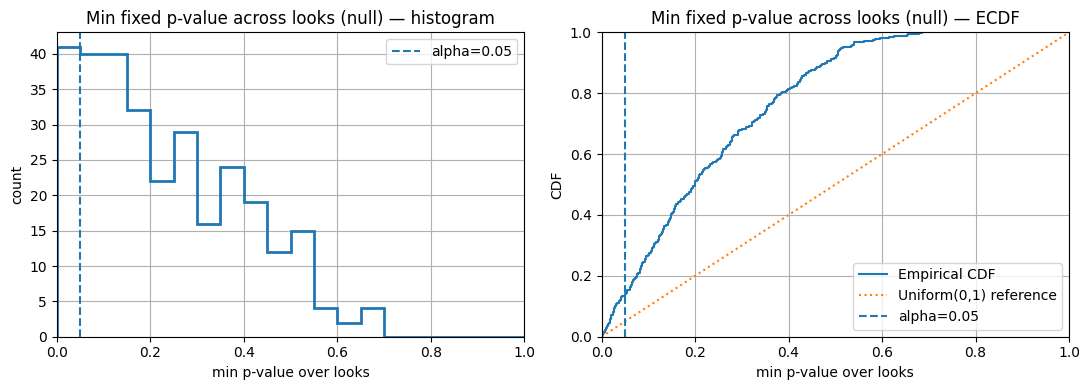

In [16]:
n_sims = 300
N = 4000
looks = [400, 800, 1200, 1600, 2000, 3000, 4000]
alpha = 0.05

naive_reject = []
gs_reject = []
gs_stop = []
min_pvals = []

spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y", timestamp_col="timestamp")
schedule = LookSchedule(looks=looks)
cfg_gs = SequentialConfig(
    mode=SequentialMode.GROUP_SEQUENTIAL,
    alpha=alpha,
    two_sided=True,
    spending=SpendingFunction.OBRIEN_FLEMING,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=10,
    var_floor=1e-12,
)

for s in range(n_sims):
    df = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.0, noise_sd=1.0, heavy_tail=False, drift=False, seed=1000 + s, ratio=False))

    # naive peeking
    naive = run_naive_peeking_mean(df, looks=looks, alpha=alpha)
    naive_reject.append(naive["rejected"])
    min_pvals.append(naive["min_p"])

    # group sequential OBF
    lt, _ = build_look_table_mean(df, spec, schedule, cfg_gs)
    res = run_group_sequential(lt, cfg_gs)
    gs_reject.append(res.decision == "reject")
    gs_stop.append(res.stop_look if res.stop_look is not None else looks[-1])

naive_type1 = float(np.mean(naive_reject))
gs_type1 = float(np.mean(gs_reject))

print("Empirical type I error (naïve peeking):", naive_type1)
print("Empirical type I error (group sequential OBF):", gs_type1)

min_pvals_arr = np.asarray(min_pvals, dtype=float)

bins = np.linspace(0.0, 1.0, 21)  

fig = plt.figure(figsize=(11, 4))
ax1 = fig.add_subplot(1, 2, 1)

ax1.hist(min_pvals_arr, bins=bins, histtype="step", linewidth=2)
ax1.axvline(alpha, linestyle="--", label=f"alpha={alpha}")
ax1.set_title("Min fixed p-value across looks (null) — histogram")
ax1.set_xlabel("min p-value over looks")
ax1.set_ylabel("count")
ax1.set_xlim(0, 1)
ax1.legend(loc="best")

ax2 = fig.add_subplot(1, 2, 2)
x = np.sort(min_pvals_arr)
y = np.arange(1, len(x) + 1) / len(x)

ax2.step(x, y, where="post", label="Empirical CDF")
ax2.plot([0, 1], [0, 1], linestyle=":", label="Uniform(0,1) reference")
ax2.axvline(alpha, linestyle="--", label=f"alpha={alpha}")

ax2.set_title("Min fixed p-value across looks (null) — ECDF")
ax2.set_xlabel("min p-value over looks")
ax2.set_ylabel("CDF")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()

## Interpretation
What happened?

- In naïve peeking, each look re-uses a fixed-horizon p-value without correcting for repeated testing. Under the null, this raises the probability of seeing a “lucky” small p-value at some look.
- In group sequential monitoring, we replace the fixed 1.96 threshold with a sequential boundary designed so the overall type I error across the pre-defined looks stays near α.

Practical takeaway (v1):

- If you want to look multiple times and keep a frequentist error guarantee, use a sequential procedure (e.g., OBF/Pocock) rather than raw p-values.

Limitations:

- This demo assumes i.i.d.-like observations; violations (drift, heavy tails) can degrade calibration and require guardrails.

## Result summary

We used a pre-defined look schedule with **K = 7** interim analyses:
`[400, 800, 1200, 1600, 2000, 3000, 4000]`, with **α = 0.05**.

Under the **null effect** (no true difference), repeated “peeking” with a standard fixed-horizon p-value inflates the false positive rate:
- **Naïve peeking** (declare significance if *any* look has fixed p < 0.05):  
  empirical type I error = **0.137** (95% MC CI: **[0.098, 0.176]**).

In contrast, a valid group sequential procedure keeps the overall error rate close to α:
- **Group sequential (O’Brien–Fleming)**:  
  empirical type I error = **0.053** (95% MC CI: **[0.028, 0.079]**).

Interpretation:
- With 7 repeated checks, naïve peeking produced about **2.6×** more false positives than the nominal 5% level.
- O’Brien–Fleming boundaries corrected for repeated looks and preserved error control within Monte Carlo noise.

Key takeaway:
- If you monitor results multiple times, **do not reuse fixed-horizon p-values**. Use **group sequential boundaries** (or anytime-valid methods) to keep frequentist guarantees intact.